In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Jul_weekday_MD.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 117467.567526
  (4,4) => 0.0
  (3,1) => 386764.905157
  (4,5) => 94370.446986
  (2,4) => 598751.270087
  (6,5) => 259938.603309
  (8,4) => 392668.536901
  (1,2) => 0.0
  (5,1) => 587604.023132
  (3,4) => 0.0
  (8,2) => 0.0
  (2,3) => 0.0
  (2,6) => 0.0
  (5,4) => 147622.6467
  (2,1) => 0.0
  (2,5) => 0.0
  (8,5) => 227968.979774
  (1,4) => 137862.886212
  (2,8) => 0.0
  (5,8) => 39870.427057
  (4,8) => 341141.772994
  (7,8) => 115886.544401
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 0.0
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Jul_dict = readall("../temp_files/link_day_minute_Jul_dict_JSON.json");
link_day_minute_Jul_dict = replace(link_day_minute_Jul_dict, "NaN", 0);

link_day_minute_Jul_dict = JSON.parse(link_day_minute_Jul_dict);

In [12]:
week_day_Jul_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30, 31]

arcs = Dict{(Int, Int), Arc}[]
for j in week_day_Jul_list
    arcs_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["MD_flow"]
        arcs_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs, arcs_)
end

In [13]:
arcs[1]

Dict{(Int64,Int64),Arc} with 24 entries:
  (3,6) => Arc(3,6,1.1419e6,10.104091401583059,784413.3117474567)
  (2,3) => Arc(2,3,376200.0,6.245983825838077,317243.5625937284)
  (5,6) => Arc(5,6,361712.5,7.596735314731068,305836.4110075608)
  (5,4) => Arc(5,4,227525.0,10.879908330347215,190960.2848672075)
  (2,1) => Arc(2,1,790400.0,14.345919651016688,668771.1698313415)
  (6,3) => Arc(6,3,926250.0,10.755524605163453,701878.3676228274)
  (3,1) => Arc(3,1,1.5238e6,20.553379146316544,1.253005658685678e6)
  (1,3) => Arc(1,3,1.4383e6,20.136411020613906,1.2075052308805045e6)
  (4,5) => Arc(4,5,218025.0,10.653322572942127,182092.4195799446)
  (4,8) => Arc(4,8,484500.0,15.071063131308403,403366.23103086546)
  (7,5) => Arc(7,5,708462.5,8.16675272101653,616492.3520315865)
  (8,7) => Arc(8,7,313500.0,8.841103424391747,260141.61763372607)
  (3,2) => Arc(3,2,471200.0,7.409576285430038,388295.14092502906)
  (7,6) => Arc(7,6,1.19129999999e6,11.056227551715708,1.0649625458283273e6)
  (2,4) => Arc(2,4,9405

In [14]:
arcs[2]

Dict{(Int64,Int64),Arc} with 24 entries:
  (3,6) => Arc(3,6,1.1419e6,10.104091401583059,753029.8943875151)
  (2,3) => Arc(2,3,376200.0,6.245983825838077,313673.06855851767)
  (5,6) => Arc(5,6,361712.5,7.596735314731068,297755.43414960685)
  (5,4) => Arc(5,4,227525.0,10.879908330347215,187785.87660465628)
  (2,1) => Arc(2,1,790400.0,14.345919651016688,668896.9075786152)
  (6,3) => Arc(6,3,926250.0,10.755524605163453,657344.2510917593)
  (3,1) => Arc(3,1,1.5238e6,20.553379146316544,1.2536933852273456e6)
  (1,3) => Arc(1,3,1.4383e6,20.136411020613906,1.1801301209978205e6)
  (4,5) => Arc(4,5,218025.0,10.653322572942127,177924.34243700886)
  (4,8) => Arc(4,8,484500.0,15.071063131308403,398262.49767935555)
  (7,5) => Arc(7,5,708462.5,8.16675272101653,600923.8867631829)
  (8,7) => Arc(8,7,313500.0,8.841103424391747,255937.94703070726)
  (3,2) => Arc(3,2,471200.0,7.409576285430038,395906.6853185107)
  (7,6) => Arc(7,6,1.19129999999e6,11.056227551715708,1.033943892496341e6)
  (2,4) => Arc(2,4,9

In [15]:
##########
# Set up demand data and flow data
##########
numData = length(arcs); 
sigma = .0

flow_data = Array(Float64, length(arcs[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data[:, iRun] = [a.flow::Float64 for a in values(arcs[iRun])]
end

In [16]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [117467.567526,117467.567526,117467.567526,117467.567526,117467.5675…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0…
  (3,1) => [386764.905157,386764.905157,386764.905157,386764.905157,386764.9051…
  (4,5) => [94370.446986,94370.446986,94370.446986,94370.446986,94370.446986,94…
  (2,4) => [598751.270087,598751.270087,598751.270087,598751.270087,598751.2700…
  (6,5) => [259938.603309,259938.603309,259938.603309,259938.603309,259938.6033…
  (8,4) => [392668.536901,392668.536901,392668.536901,392668.536901,392668.5369…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0…
  (5,1) => [587604.023132,587604.023132,587604.023132,587604.023132,587604.0231…
  (3,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0…
  (8,2) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0…
  (2,3) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [17]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [18]:
#include("trafficCval.jl")

arcs6 = arcs[1]
arcs7 = arcs[1]
arcs8 = arcs[1]
arcs9 = arcs[1]
coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

# deg = 6
deg = 6
c = 1.
lam = 1e1

fcoeffs6 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs6)
coeffs_dict[(deg, c, lam)] = fcoeffs6

# deg = 7
deg = 7
c = 1.
lam = 1e1

fcoeffs7 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs7)
coeffs_dict[(deg, c, lam)] = fcoeffs7

# deg = 8
deg = 8
c = 1.
lam = 5.

fcoeffs8 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs8)
coeffs_dict[(deg, c, lam)] = fcoeffs8

# deg = 9
deg = 9
c = 1.
lam = 5.

fcoeffs9 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs9)
coeffs_dict[(deg, c, lam)] = fcoeffs9

981.2873585306894
972.03350985114
970.8942319215333
970.7886128547566


10-element Array{Float64,1}:
  0.436654 
 -0.312022 
 -0.315956 
  0.0285805
  2.40445  
 -2.63654  
  6.36515  
 -6.26198  
  3.12796  
 -0.771917 

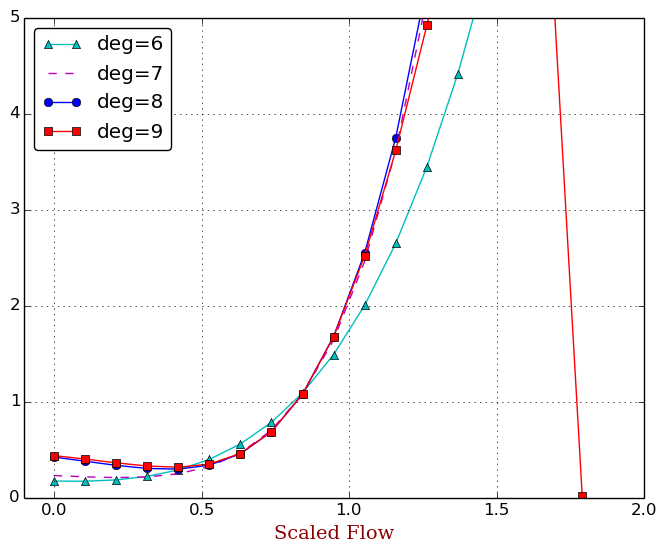

In [23]:
using PyPlot

#true_coeffs = [1, 0, 0, 0, .15]
fcoeffs6 = coeffs_dict[(6, 1., 1e1)]
fcoeffs7 = coeffs_dict[(7, 1., 1e1)]
fcoeffs8 = coeffs_dict[(8, 1., 5.)]
fcoeffs9 = coeffs_dict[(9, 1., 5.)]

xs = linspace(0, 2, 20)
#ys_true = map(x->polyEval(true_coeffs, x), xs)
ys6 = map(x->polyEval(fcoeffs6, x), xs)
ys7 = map(x->polyEval(fcoeffs7, x), xs)
ys8 = map(x->polyEval(fcoeffs8, x), xs)
ys9 = map(x->polyEval(fcoeffs9, x), xs)

# ys = map(x->polyEval(fcoeffs, x), xs)

#plot(xs, ys_true, "k", label="True")
plot(xs, ys6, "^-c", label="deg=6")
plot(xs, ys7, "--m", label="deg=7")
plot(xs, ys8, "o-b", label="deg=8")
plot(xs, ys9, "s-r", label="deg=9")
legend(loc="upper left",fancybox="true") 
# plot(xs, ys, "--b")
grid("on")
xlim(-0.1, 2.0);
ylim(0.0, 5.0);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Jul_MD.pdf")

In [20]:
fcoeffs8, fcoeffs9

([0.210522,0.376149,-0.195695,-0.422682,-0.210552,2.18045,-0.459555,1.06335,-0.183748],[0.200107,0.448582,-0.0812066,-0.494983,-1.10722,4.00568,-3.55291,4.80952,-2.31816,0.490425])

In [21]:
s = "{\"fcoeffs6\": $(fcoeffs6), \"fcoeffs7\": $(fcoeffs7), \"fcoeffs8\": $(fcoeffs8), \"fcoeffs9\": $(fcoeffs9)}"

outfile = open("../temp_files/fcoeffs_Jul_MD.json", "w")

JSON.print(outfile, s)

close(outfile)

In [24]:
fcoeffs_Jul_MD = readall("../temp_files/fcoeffs_Jul_MD.json")
fcoeffs_Jul_MD = JSON.parse(JSON.parse(fcoeffs_Jul_MD))

Dict{String,Any} with 4 entries:
  "fcoeffs7" => {0.22893304309661114,-0.14178187506466297,0.04966369060372,0.50…
  "fcoeffs8" => {0.4214125457680624,-0.39181232601607996,-0.26943870918893004,0…
  "fcoeffs6" => {0.17136450135973086,-0.07473401586120726,0.4459411700023977,0.…
  "fcoeffs9" => {0.43665376192665584,-0.3120216620312617,-0.3159560430583176,0.…